# Transfer learning with PyTorch

In this example we'll implement fine-tuning and feature extracting transfer learning using the CIFAR-10 dataset.

_This example is partially based on_ [https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py](https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py).<br/>
_The licensing information and the author of the base version are:<br/>
License: BSD<br/>
Author: Sasank Chilamkurthy_

Let's start with the imports:

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
import numpy as np
import random
from torch.utils.data import Subset, DataLoader, Dataset


We'll continue with the training and validation batch size:

In [2]:
batch_size = 50
m = 3
n = 3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
train_data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_data_transform = transforms.Compose([
transforms.Resize(224),
transforms.ToTensor(),
transforms.Normalize((0.4914, 0.4821, 0.4465), (0.2470, 0.2435,
0.2616))
])

In [4]:
class CIFAR_Dataset(Dataset):
    def __init__(self, train=True, download=True, img_transforms=None):
        '''
        data - cifar data path
        '''

        self.img = torchvision.datasets.CIFAR10(root='./data',
                                         train=train,
                                         download=download,
                                         transform=img_transforms)
        self.img_transforms = img_transforms


    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
      if self.img_transforms is None:
        image = self.img.data[idx]
        label = self.img.targets[idx]

      else:
        image = self.img[idx][0]
        label = self.img[idx][1]


      return image, label

In [5]:
train_dataset = CIFAR_Dataset()
test_dataset = CIFAR_Dataset(train=False)
class_names = train_dataset.img.classes


100%|██████████| 170M/170M [00:04<00:00, 41.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
train_dataset_transformed = CIFAR_Dataset(img_transforms=train_data_transform)
test_dataset_transformed = CIFAR_Dataset(train=False, img_transforms=test_data_transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
indices = np.random.choice(len(train_dataset), size=m * n, replace=False)  # Elegir índices aleatorios

In [9]:
def show_original_images(dataset, m, n):
    """
    Muestra una cuadrícula m x n de imágenes originales del dataset sin transformaciones.
    """
    fig, axs = plt.subplots(m, n, figsize=(n*2 , m*2 ))
    #indices = np.random.choice(len(dataset), size=m * n, replace=False)  # Elegir índices aleatorios


    for i, ax in enumerate(axs.flat):
        img, lab = dataset[indices[i]]
        ax.imshow(img)
        ax.set_title(class_names[lab])
        ax.axis('off')

    fig.subplots_adjust(wspace=3, hspace=3)
    plt.tight_layout()
    plt.show()



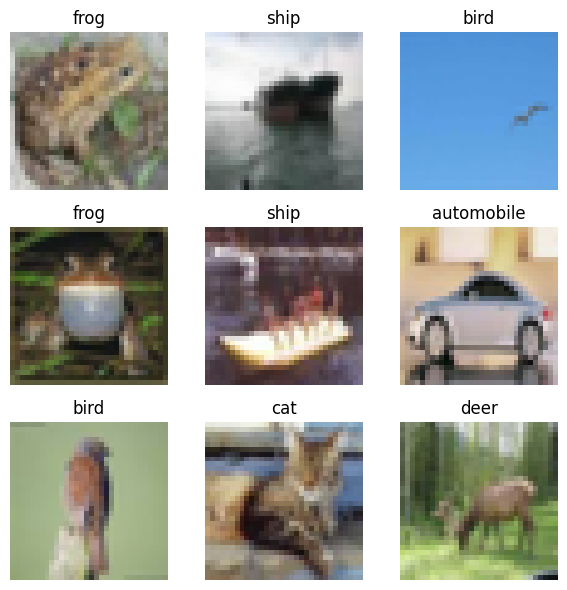

In [10]:
show_original_images(train_dataset, m=3, n=3)

In [11]:
def show_transformed_dataset(dataset, m, n):
    """
    Muestra una cuadrícula m x n de las mismas imágenes, pero con las transformaciones aplicadas.
    """
    fig, axs = plt.subplots(m, n, figsize=(n*2 , m*2 ))
    #indices = np.random.choice(len(dataset), size=m * n, replace=False)

    for i, ax in enumerate(axs.flat):
        image, label = dataset[indices[i]]  # Aplicar transformaciones
        image = image.numpy().transpose((1, 2, 0))  # Cambiar ejes
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean  # Desnormalizar
        image = np.clip(image, 0, 1)  # Limitar los valores a [0, 1]


        ax.imshow(image)
        ax.set_title(class_names[label])
        ax.axis('off')

    fig.subplots_adjust(wspace=3, hspace=3)
    plt.tight_layout()
    plt.show()


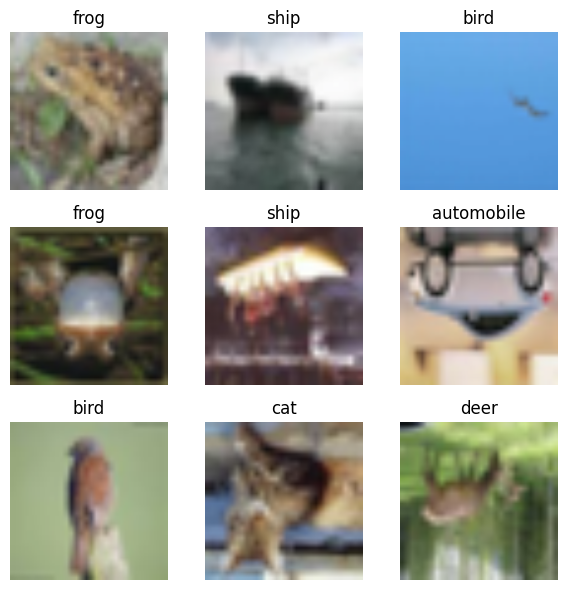

In [12]:
show_transformed_dataset(train_dataset_transformed, m=3, n=3)

In [13]:

random_index_train = np.random.randint(0, len(train_dataset_transformed), 1000)
random_index_test = np.random.randint(0, len(test_dataset), 1000)
train_subset = Subset(train_dataset_transformed, random_index_train)
test_subset = Subset(test_dataset_transformed, random_index_test)



In [14]:
len(test_subset)

1000

Next, we'll define the train data loader. `train_data_transform` resizes the CIFAR images to match the transfer learning model input size. The function also applies basic data augmentation techniques:

In [15]:
train_loader = torch.utils.data.DataLoader(train_subset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(test_subset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=2)



In [16]:
len(test_loader)

20

In [17]:
batches_predictions_train = []
batches_predictions_test = []

Let's define the training procedure:

In [25]:
def train_model(model, loss_function, optimizer, data_loader, save_prediction= False):
    # set model to training mode
    model.train()

    current_loss = 0.0
    current_acc = 0

    # iterate over the training data
    for i, (inputs, labels) in enumerate(data_loader):
        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            # forward
            outputs = model(inputs)
            _, prediction = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            # backward
            loss.backward()
            optimizer.step()

        if save_prediction == True:

          # Guardar predicciones del batch como un diccionario
          batch_data = {
          "predictions": prediction.cpu().numpy(),
          "labels": labels.cpu().numpy()
          }
          batches_predictions_train.append(batch_data)

        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(prediction == labels.data)


    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)
    total_acc = total_acc.cpu().item()

    print('Train Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))

    return total_loss, total_acc

We'll continue with the test procedure:

In [26]:
def test_model(model, loss_function, data_loader, save_prediction = False):
    # set model in evaluation mode
    model.eval()

    current_loss = 0.0
    current_acc = 0

    # iterate over  the validation data
    for i, (inputs, labels) in enumerate(data_loader):

        # send the input/labels to the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)
        if save_prediction == True:

          # Guardar predicciones del batch como un diccionario
          batch_data = {
          "predictions": predictions.cpu().numpy(),
          "labels": labels.cpu().numpy()
          }
          batches_predictions_test.append(batch_data)
        # statistics
        current_loss += loss.item() * inputs.size(0)
        current_acc += torch.sum(predictions == labels.data)


    total_loss = current_loss / len(data_loader.dataset)
    total_acc = current_acc.double() / len(data_loader.dataset)
    total_acc = total_acc.cpu().item()

    print('Test Loss: {:.4f}; Accuracy: {:.4f}'.format(total_loss, total_acc))

    return total_loss, total_acc

Next, we'll define 2 functions that build transfer learning models for either feature extacting, or fine-tuning. Both models use the `torchvision.models.resnet18` ImageNet pretrained model. We'll start with feature extracting, which "locks" all model parameters (weights) except for the final fully-connected layer:

In [27]:
def tl_feature_extractor(epochs=10):
    # load the pre-trained model
    model = torchvision.models.resnet18(pretrained=True)

    # exclude existing parameters from backward pass
    # for performance
    for param in model.parameters():
        param.requires_grad = False

    # newly constructed layers have requires_grad=True by default
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)

    # transfer to GPU (if available)
    model = model.to(device)

    loss_function = nn.CrossEntropyLoss()

    # only parameters of the final layer are being optimized
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

    # save batches prediction for train and test
    batches_predictions_train = []
    batches_prediction_test = []

    # train
    test_acc = list()  # collect accuracy for plotting
    train_acc = list()
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch + 1, epochs))
        if epoch == epochs - 1:
          save_prediction = True
          _, acc_train = train_model(model, loss_function, optimizer, train_loader, save_prediction)
          _, acc_test = test_model(model, loss_function, test_loader, save_prediction)
        else:
          _, acc_train = train_model(model, loss_function, optimizer, train_loader)
          _, acc_test = test_model(model, loss_function, test_loader)
        test_acc.append(acc_test)
        train_acc.append(acc_train)


    plot_accuracy(train_acc, test_acc)




We'll continue with the fine-tuning model, which trains all weights of the network:

Let's define the `plot_accuracy` function:

In [21]:
def plot_accuracy(accuracy_train: list, accuracy_test: list):
    """Plot accuracy"""
    plt.figure()
    plt.plot(accuracy_train, label='Train')
    plt.plot(accuracy_test, label='Test')
    plt.xticks(
        [i for i in range(0, len(accuracy_train))],
        [i + 1 for i in range(0, len(accuracy_train))])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

Finally, we can put everything together and run the training. Let's start with the feature extracting model:

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
Train Loss: 2.2436; Accuracy: 0.1840
Test Loss: 1.9979; Accuracy: 0.2970
Epoch 2/30
Train Loss: 1.8431; Accuracy: 0.3880
Test Loss: 1.6926; Accuracy: 0.4740
Epoch 3/30
Train Loss: 1.5986; Accuracy: 0.4920
Test Loss: 1.4716; Accuracy: 0.5510
Epoch 4/30
Train Loss: 1.4341; Accuracy: 0.5410
Test Loss: 1.3526; Accuracy: 0.5760
Epoch 5/30
Train Loss: 1.3064; Accuracy: 0.6040
Test Loss: 1.2639; Accuracy: 0.6080
Epoch 6/30
Train Loss: 1.2229; Accuracy: 0.6340
Test Loss: 1.1958; Accuracy: 0.6220
Epoch 7/30
Train Loss: 1.1539; Accuracy: 0.6440
Test Loss: 1.1467; Accuracy: 0.6330
Epoch 8/30
Train Loss: 1.1108; Accuracy: 0.6670
Test Loss: 1.1110; Accuracy: 0.6430
Epoch 9/30
Train Loss: 1.0621; Accuracy: 0.6730
Test Loss: 1.0749; Accuracy: 0.6560
Epoch 10/30
Train Loss: 1.0193; Accuracy: 0.6880
Test Loss: 1.0532; Accuracy: 0.6550
Epoch 11/30
Train Loss: 0.9938; Accuracy: 0.6990
Test Loss: 1.0260; Accuracy: 0.6700
Epoch 12/30
Train Loss: 0.9448; Accuracy: 0.6970
Test Loss: 1.0044; Accura

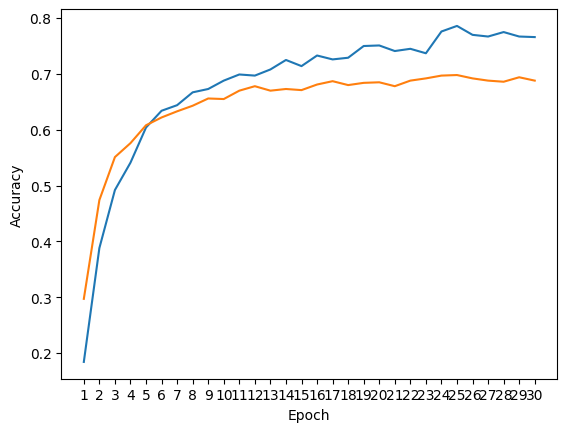

In [28]:
tl_feature_extractor(epochs=30)

In [29]:
def show_images(dataset, predictions,random_index, m, n, batch_size, batch_number):
    """
    Muestra una cuadrícula m x n de imágenes originales del dataset sin transformaciones.
    """


    indices = np.random.choice(batch_size, size=m * n, replace=False)  # Elegir índices aleatorios
    #indices = np.arange(9)
    indx = [random_index[batch_number*batch_size+i] for i in indices]
    print('indx', indx)

    pred = predictions[batch_number]['predictions'][indices]
    lab1 = predictions[batch_number]['labels'][indices]

    # dataset-data accede a los datos originales
    imgs = [dataset[i][0] for i in indx]  # Dataset original (CIFAR-10 sin transformar)
    lab = [dataset[i][1] for i in indx]  # Etiquetas originales



    print(lab1)
    print(pred)
    print(lab)



    fig, axs = plt.subplots(m, n, figsize=(n*2 , m*2 ))

    for i, ax in enumerate(axs.flat):
        image = imgs[i]
        ax.imshow(image)


        ax.set_title( f'{class_names[lab[i]]} / {class_names[pred[i]]}')
        ax.axis('off')

    fig.subplots_adjust(wspace=3, hspace=3)
    plt.tight_layout()
    plt.show()





indx [17147, 30463, 44506, 9983, 19829, 13154, 13072, 29450, 14464]
[4 1 5 0 8 2 8 5 8]
[4 1 5 0 8 2 8 5 8]
[4, 1, 5, 0, 8, 2, 8, 5, 8]


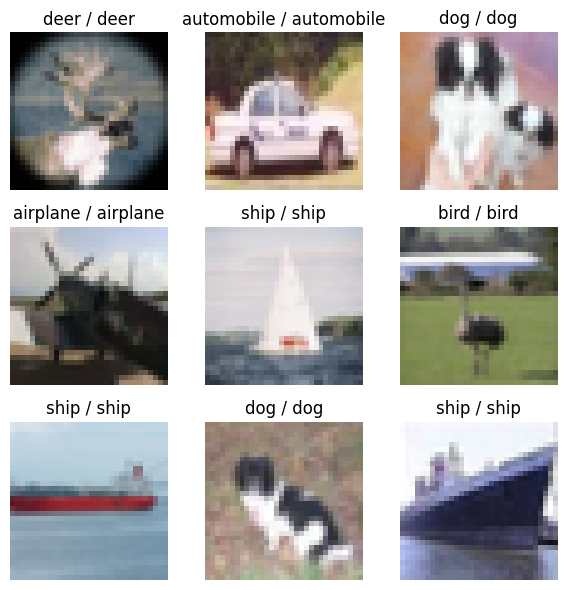

In [40]:
show_images(train_dataset,batches_predictions_train, random_index_train, 3, 3, 50, 11)

indx [4235, 2443, 6042, 7217, 7760, 3770, 585, 7910, 9527]
[9 2 6 8 2 9 9 3 6]
[9 0 0 0 9 9 9 3 2]
[9, 2, 6, 8, 2, 9, 9, 3, 6]


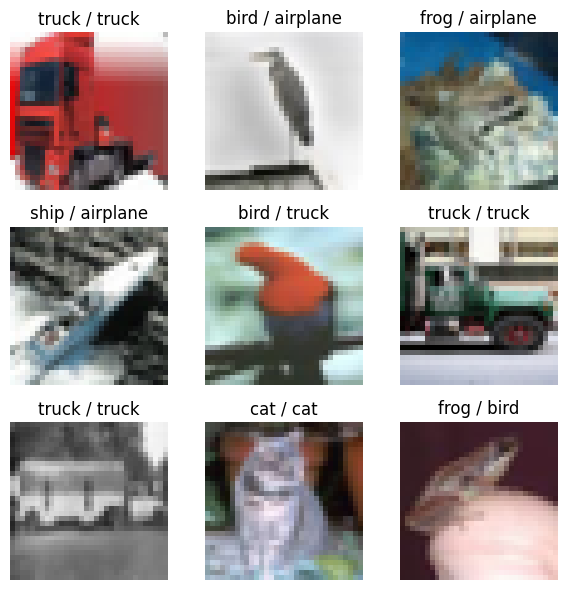

In [44]:
show_images(test_dataset, batches_predictions_test, random_index_test, 3, 3, 50, 0)

In [ ]:
len(batches_predictions_test)

0

In [ ]:
len(batches_predictions_train)

print(batches_predictions_train[1]['labels'])

[6 5 3 5 5 4 1 9 4 6 1 0 2 3 1 4 7 8 6 4 1 4 2 1 0 0 8 6 4 7 4 0 0 9 2 7 0
 5 0 3 3 0 1 5 8 3 2 8 7 7]


In [ ]:
for i, img in enumerate(train_loader):
  Img = img
  break

50
torch.Size([50, 3, 224, 224])
0
tensor(6)
1
tensor(9)
2
tensor(9)
3
tensor(4)
4
tensor(1)
5
tensor(1)
6
tensor(2)
7
tensor(7)
8
tensor(8)


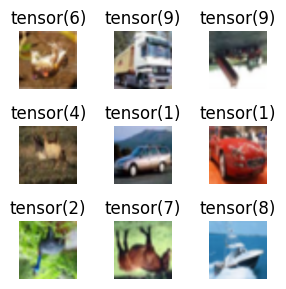

In [ ]:
print(len(Img[0]))
print(Img[0].shape)
fig, axs = plt.subplots(3, 3, figsize=(3 , 3 ))



#for i in range(9):
for i, ax in enumerate(axs.flat):
  print(i)

  image = Img[0][i] # Aplicar transformaciones
  label = Img[1][i]
  print(label)
  image = image.numpy().transpose((1, 2, 0))  # Cambiar ejes
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean  # Desnormalizar
  image = np.clip(image, 0, 1)  # Limitar los valores a [0, 1]
  ax.imshow(image)
  ax.set_title(label)
  ax.axis('off')

plt.tight_layout()
plt.show()


We can also run the fine-tuninig model for comparison:

Epoch 1/5
Train Loss: 0.8057; Accuracy: 0.7192
Test Loss: 0.6171; Accuracy: 0.7790
Epoch 2/5
Train Loss: 0.5269; Accuracy: 0.8180
Test Loss: 0.5153; Accuracy: 0.8221
Epoch 3/5
Train Loss: 0.4272; Accuracy: 0.8539
Test Loss: 0.4016; Accuracy: 0.8589
Epoch 4/5
Train Loss: 0.3642; Accuracy: 0.8751
Test Loss: 0.3933; Accuracy: 0.8642
Epoch 5/5
Train Loss: 0.3180; Accuracy: 0.8910
Test Loss: 0.3768; Accuracy: 0.8712


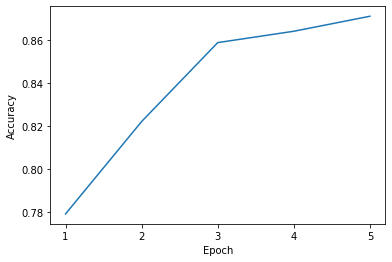

In [ ]:
tl_fine_tuning(epochs=5)

The feature extracting model achieves high validation accuracy even after the first epoch, but taps out after that. That's because the model capacity is limited, since only the final fully-connected layer weights are trainable. On the other hand the fine-tuning model uses it's full capacity and achieves higher overall accuracy.

In [ ]:
# load the pre-trained model
model = torchvision.models.resnet18(pretrained=True)

# exclude existing parameters from backward pass
# for performance
for param in model.parameters():
    param.requires_grad = False

# newly constructed layers have requires_grad=True by default
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# transfer to GPU (if available)
model = model.to(device)

loss_function = nn.CrossEntropyLoss()

# only parameters of the final layer are being optimized
optimizer = optim.Adam(model.fc.parameters())

# train

predictions = train_model(model, loss_function, optimizer, train_loader)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


KeyboardInterrupt: 